### Read OISST v2 data via Thredds and test the marineHeatWaves algorithm

In [1]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import xarray as xr
# Load marineHeatWaves definition module
import marineHeatWaves as mhw

In [2]:
base_url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/'
files = [f'{base_url}sst.day.mean.{year}.v2.nc' for year in range(1981, 2021)]
files
#https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc.html

['https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1981.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1982.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1983.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1984.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1985.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1986.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1987.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1988.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1989.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.day.mean.1990.v2.nc',
 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.

In [3]:
%%time
data = xr.open_mfdataset(files)

CPU times: user 474 ms, sys: 52.6 ms, total: 527 ms
Wall time: 8.41 s


### Marine Heatwave Detection
The marineHeatWaves (mhw) module consists of a number of functions for the detection and characterization of MHWs. The main function is the detection function (detect) which takes as input a time series of temperature (and a corresponding time vector) and outputs a set of detected MHWs.

#### Case study #1: 2011 Western Australia event
As an example, let's load a daily time series of SST off Western Australia (WA; 112.5 ∘ E, 29.5 ∘ S) over the 1982 to 2014 period, remotely-sensed from the AVHRR satellite platform:

### Let's look at the point for case 1 in a map

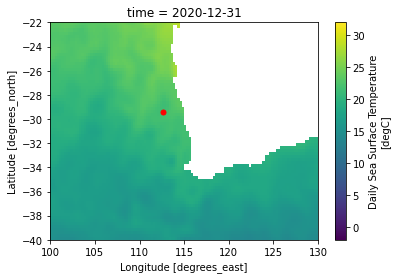

In [4]:
%matplotlib inline
dummy = data.sst.sel(lon = 112.5, lat = -29.5, method='nearest')[0]
fig, ax = plt.subplots(1,1)
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_xlim(100,130)
ax.set_ylim(-40,-22);

Looks good! We can now extract a time series for SST at this point.

In [6]:
%%time
wa_ds = data.sst.sel(lon = 112.5, lat = -29.5, 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 294 ms, sys: 41 ms, total: 335 ms
Wall time: 6min 2s


In [7]:
wa_ds.to_netcdf('wa_ds.nc')

In [17]:
#Uncomment line below to start from here
wa_ds=xr.open_dataset('wa_ds.nc').sst

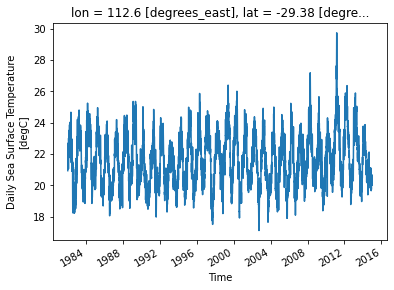

In [18]:
wa_ds.plot()

Next we run the MHW detection algorithm which returns the variable mhws, consisting of the detected MHWs, and clim, consisting of the climatological (varying by day-of-year) seasonal cycle and extremes threshold:

In [126]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [127]:
len(t)

12053

In [20]:
mhws_case1, clim_case1 = mhw.detect(t, wa_ds.values)

This algorithm has detected the following number of MHW events:

In [21]:
mhws_case1['n_events']

60

The first ten events, for example, have the following maximum intensities (in C)  

In [22]:
mhws_case1['intensity_max'][0:10]

[1.9759563938263902,
 2.1255383645334582,
 2.241348082019435,
 1.2863466816563793,
 1.8312707716418863,
 1.5018472363871922,
 2.2082389708488286,
 1.1157563117242653,
 1.690619499452648,
 1.9938329881237422]

Let's have a look at some properties of the event with the largest maximum intensity

In [23]:
ev = np.argmax(mhws_case1['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws_case1['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case1['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case1['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case1['duration'][ev], 'days')
print ('Start date:', mhws_case1['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case1['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 6.483709366090839 deg. C
Average intensity: 3.176277888886581 deg. C
Cumulative intensity: 193.75295122208144 deg. C-days
Duration: 61 days
Start date: 06 February 2011
End date: 07 April 2011


This turns out to be the infamous 2011 MHW off WA. Let's plot the SST time series over the full record and also have a closer look at the identified MHW event:

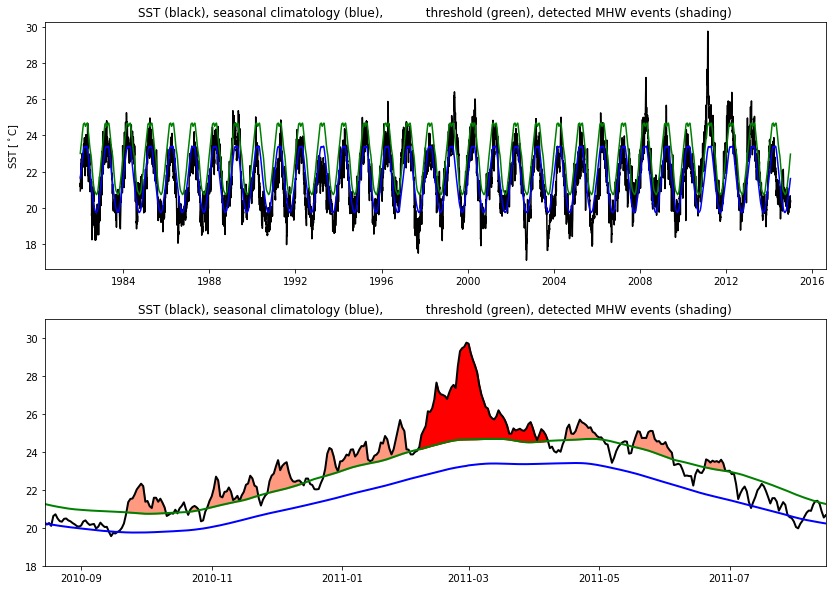

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, wa_ds.values, 'k-')
plt.plot(dates, clim_case1['thresh'], 'g-')
plt.plot(dates, clim_case1['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(t[0], t[-1])
plt.ylim(wa_ds.min()-0.5, wa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case1['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws_case1['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim_case1['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2011 WA event) and shade accordingly
t1 = np.where(t==mhws_case1['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case1['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], wa_ds[t1:t2+1], clim_case1['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, wa_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case1['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case1['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
#plt.xlim(mhws['time_start'][ev]-150, mhws['time_end'][ev]+150)
#plt.ylim(clim_case1['seas'].min() - 1, clim_case1['seas'].max() + mhws_case1['intensity_max'][ev] + 0.5)
#plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(date(2010,8,15), date(2011,8,15))
plt.ylim(18,31);

In [37]:
mhws_case1['date_start'] [15:35]

[datetime.date(1996, 4, 15),
 datetime.date(1996, 8, 21),
 datetime.date(1996, 9, 9),
 datetime.date(1996, 11, 17),
 datetime.date(1997, 1, 7),
 datetime.date(1998, 8, 24),
 datetime.date(1999, 5, 13),
 datetime.date(2000, 4, 21),
 datetime.date(2000, 11, 13),
 datetime.date(2004, 5, 4),
 datetime.date(2005, 7, 22),
 datetime.date(2007, 7, 27),
 datetime.date(2007, 8, 13),
 datetime.date(2007, 9, 16),
 datetime.date(2007, 10, 22),
 datetime.date(2008, 3, 26),
 datetime.date(2008, 5, 6),
 datetime.date(2008, 7, 3),
 datetime.date(2008, 8, 30),
 datetime.date(2008, 9, 26)]

In [38]:
mhws_case1['date_end'][15:35]

[datetime.date(1996, 4, 24),
 datetime.date(1996, 8, 25),
 datetime.date(1996, 9, 13),
 datetime.date(1996, 12, 24),
 datetime.date(1997, 1, 20),
 datetime.date(1998, 9, 12),
 datetime.date(1999, 8, 15),
 datetime.date(2000, 5, 19),
 datetime.date(2000, 11, 17),
 datetime.date(2004, 5, 8),
 datetime.date(2005, 8, 4),
 datetime.date(2007, 8, 5),
 datetime.date(2007, 8, 24),
 datetime.date(2007, 9, 24),
 datetime.date(2007, 10, 26),
 datetime.date(2008, 4, 28),
 datetime.date(2008, 5, 13),
 datetime.date(2008, 7, 10),
 datetime.date(2008, 9, 8),
 datetime.date(2008, 10, 4)]

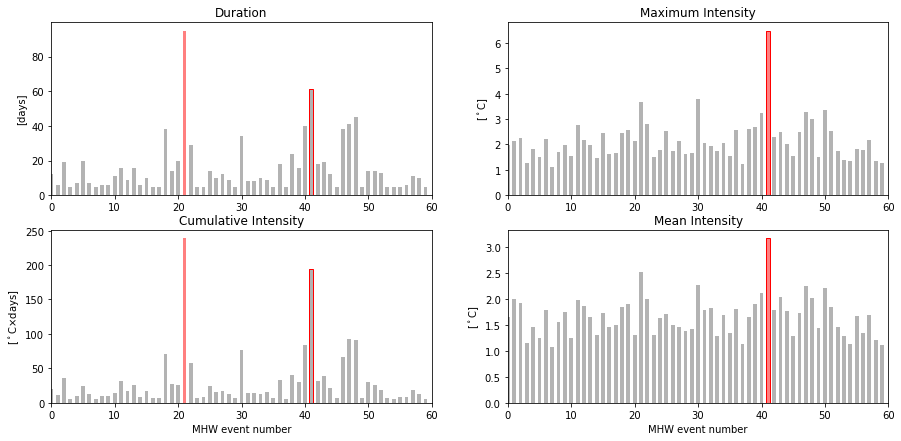

In [14]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case1['duration'])
plt.bar(range(mhws_case1['n_events']), mhws_case1['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case1['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case1['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case1['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case1['intensity_max'])
plt.bar(range(mhws_case1['n_events']), mhws_case1['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case1['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case1['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case1['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case1['intensity_mean'])
plt.bar(range(mhws_case1['n_events']), mhws_case1['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case1['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case1['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case1['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case1['intensity_cumulative'])
plt.bar(range(mhws_case1['n_events']), mhws_case1['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case1['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case1['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case1['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

In [15]:
rank, returnPeriod = mhw.rank(t, mhws_case1)
print ("The 2011 WA event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2011 WA event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2011 WA event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2011 WA event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2011 WA event is ranked number 2 by duration
The 2011 WA event is ranked number 1 by maximum intensity
The 2011 WA event is ranked number 1 by mean intensity
The 2011 WA event is ranked number 2 by cumulative intensity


#### Case study \#2: 2012 Northwest Atlantic event

We can also have a look at the 2012 Northwest Atlantic (NWA) event. Let's load a daily time series of SST from the NWA (67 ∘ W, 43 ∘ N) from the same data set as above and repeat the analysis:



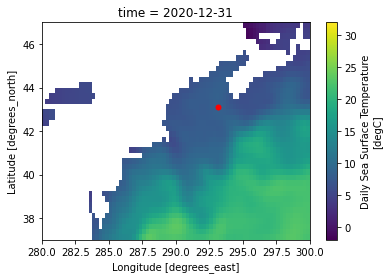

In [170]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 293, lat = 43, method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(37,47)
ax.set_xlim(280,300);

In [ ]:
%%time
nwa_ds = data.sst.sel(lon = 293., lat = 43., 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

In [69]:
#nwa_ds.to_netcdf('nwa_ds.nc')

In [70]:
#Uncomment line below to start from here
nwa_ds=xr.open_dataset('nwa_ds.nc').sst

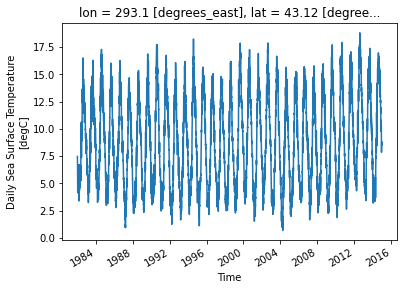

In [71]:
nwa_ds.plot()

In [72]:
# Detect MHW events
mhws_case2, clim_case2 = mhw.detect(t, nwa_ds.values)

In [73]:
mhws_case2.keys()

dict_keys(['time_start', 'time_end', 'time_peak', 'date_start', 'date_end', 'date_peak', 'index_start', 'index_end', 'index_peak', 'duration', 'duration_moderate', 'duration_strong', 'duration_severe', 'duration_extreme', 'intensity_max', 'intensity_mean', 'intensity_var', 'intensity_cumulative', 'intensity_max_relThresh', 'intensity_mean_relThresh', 'intensity_var_relThresh', 'intensity_cumulative_relThresh', 'intensity_max_abs', 'intensity_mean_abs', 'intensity_var_abs', 'intensity_cumulative_abs', 'category', 'rate_onset', 'rate_decline', 'n_events'])

In [83]:
mhws_case2['n_events']

49

In [77]:
clim_case2['seas']

array([6.41527364, 6.34090059, 6.26747927, ..., 6.64348925, 6.56630982,
       6.4903674 ])

In [23]:
# Find largest event
ev = np.argmax(mhws_case2['intensity_max'])
print ('Maximum intensity:', mhws_case2['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case2['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case2['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case2['duration'][ev], 'days')
print ('Start date:', mhws_case2['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case2['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 4.758620846656061 deg. C
Average intensity: 2.550958615970375 deg. C
Cumulative intensity: 132.6498480304595 deg. C-days
Duration: 52 days
Start date: 10 April 2012
End date: 31 May 2012


Again, the event with largest maximum intensity turns out to be an event known in the literature: the 2012 NWA event. Let's plot it as above:

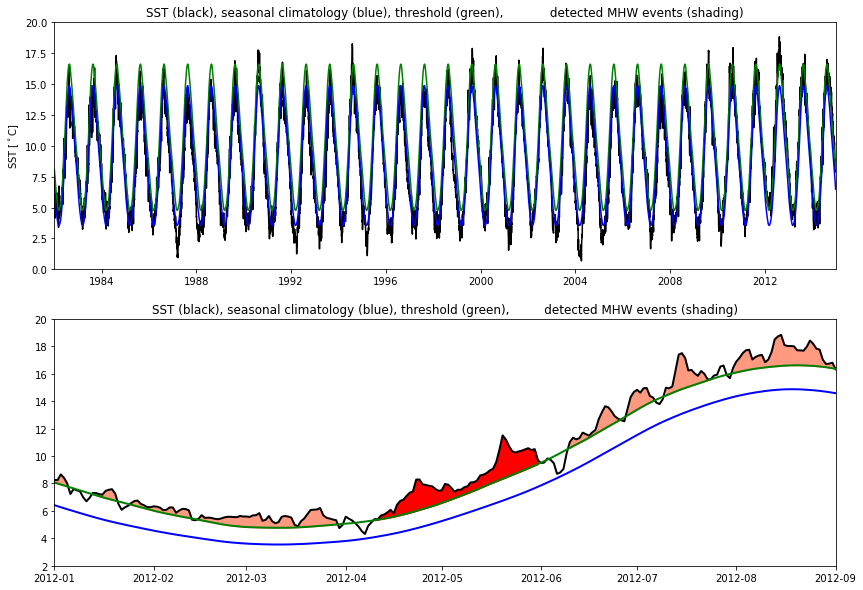

In [24]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, nwa_ds, 'k-')
plt.plot(dates, clim_case2['thresh'], 'g-')
plt.plot(dates, clim_case2['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(nwa_ds.min()-0.5, nwa_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(0,20);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case2['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws_case2['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], nwa_ds[t1:t2+1], clim_case2['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case2['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case2['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], nwa_ds[t1:t2+1], clim_case2['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, nwa_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case2['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case2['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim(date(2012,1,1), date(2012,9,1))
plt.ylim(2,20);

Interestingly, the 2012 NWA event doesn't appear to be as intense as the 2011 WA event. That is partly because it occured outside the summer months. It is nonetheless the largest event on record according to maximum intensity:

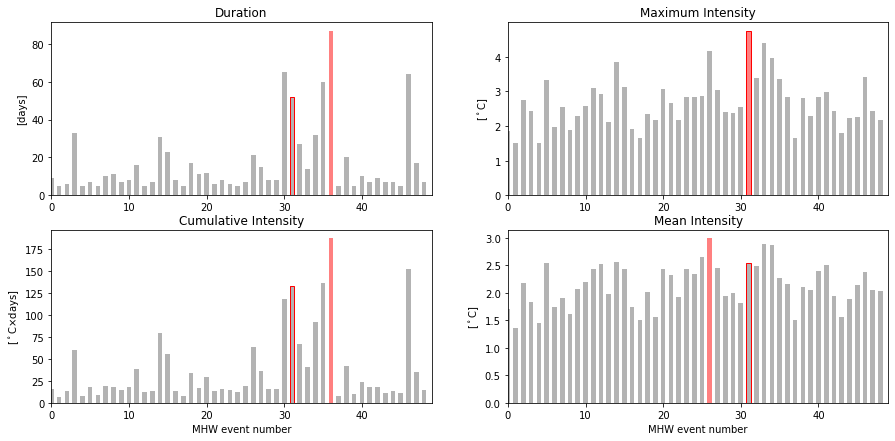

In [25]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case2['duration'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case2['intensity_max'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case2['intensity_mean'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case2['intensity_cumulative'])
plt.bar(range(mhws_case2['n_events']), mhws_case2['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case2['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case2['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case2['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

However, the 2012 NWA event (red outlined bars) is not the highest ranked event (red shaded bars) when sorted according to mean intensity, cumulative intenstiy and duration:

In [26]:
#mhws_case2.rank

In [27]:
rank, returnPeriod = mhw.rank(t, mhws_case2)
print ("The 2012 NWA event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2012 NWA event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2012 NWA event is ranked number 5 by duration
The 2012 NWA event is ranked number 1 by maximum intensity
The 2012 NWA event is ranked number 6 by mean intensity
The 2012 NWA event is ranked number 4 by cumulative intensity


#### Case study #3: 2003 Mediterranean event

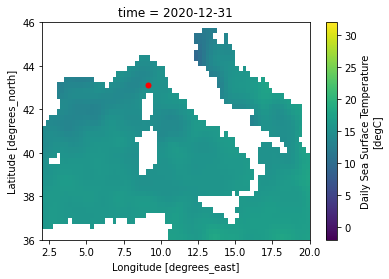

In [28]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 9, lat =43, method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(36,46)
ax.set_xlim(2,20);

In [8]:
%%time
med_ds = data.sst.sel(lon = 9, lat = 43, 
             method='nearest').sel(time = slice("1982-01-01","2014-12-31")).load()

CPU times: user 274 ms, sys: 49.5 ms, total: 324 ms
Wall time: 5min 56s


In [9]:
type(med_ds)

xarray.core.dataarray.DataArray

In [10]:
med_ds.to_netcdf('med_ds.nc')

In [40]:
#Uncomment line below to start from here
med_ds=xr.open_dataset('med_ds.nc').sst

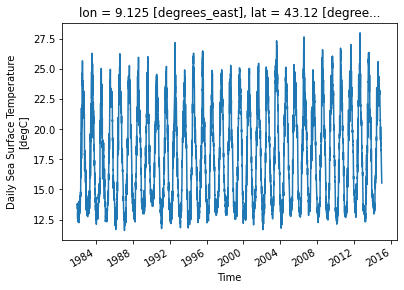

In [42]:
med_ds.plot()

In [43]:
# Detect MHW events
mhws_case3, clim_case3 = mhw.detect(t, med_ds.values)

In [44]:
# Find largest event
ev = np.argmax(mhws_case3['intensity_max'])
print ('Maximum intensity:', mhws_case3['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case3['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case3['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case3['duration'][ev], 'days')
print ('Start date:', mhws_case3['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case3['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 4.630774221112652 deg. C
Average intensity: 3.7618240233390576 deg. C
Cumulative intensity: 116.61654472351078 deg. C-days
Duration: 31 days
Start date: 01 June 2003
End date: 01 July 2003


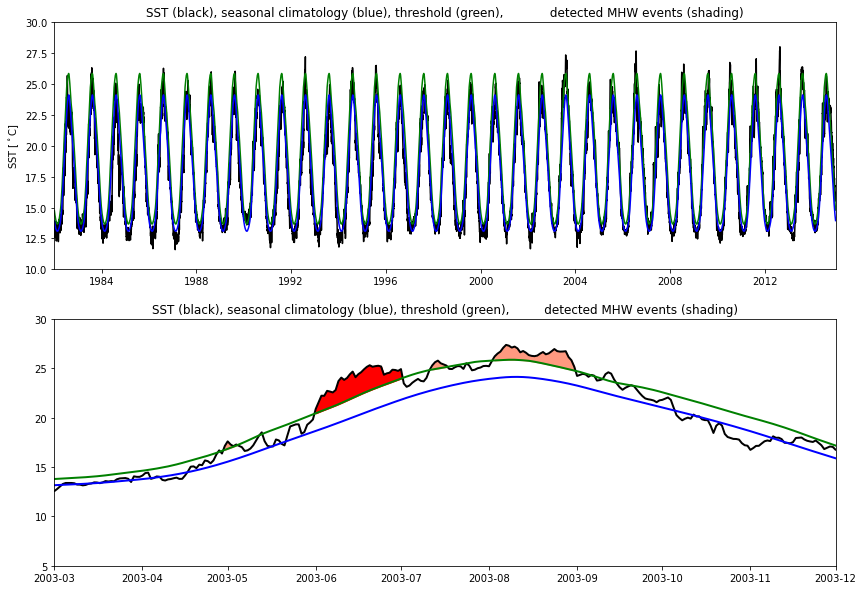

In [46]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, med_ds, 'k-')
plt.plot(dates, clim_case3['thresh'], 'g-')
plt.plot(dates, clim_case3['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(med_ds.min()-0.5, med_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(10,30);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case3['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws_case3['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], med_ds[t1:t2+1], clim_case3['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case3['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case3['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], med_ds[t1:t2+1], clim_case3['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, med_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case3['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case3['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim(date(2003,3,1), date(2003,12,1))
plt.ylim(5,30);

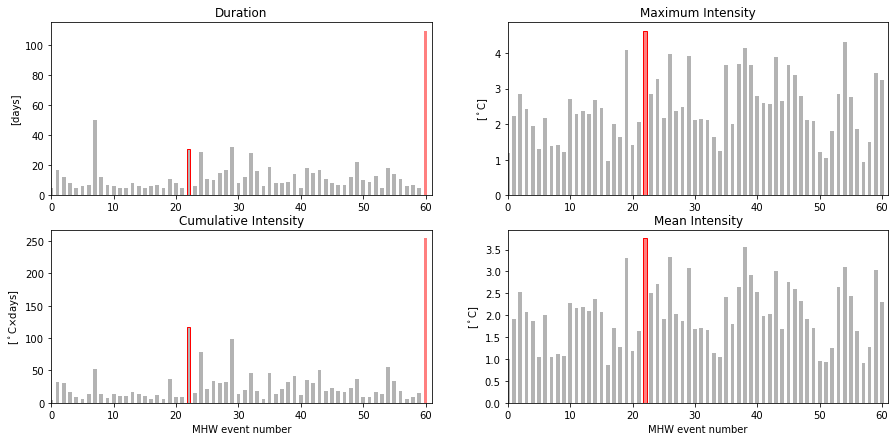

In [47]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case3['duration'])
plt.bar(range(mhws_case3['n_events']), mhws_case3['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case3['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case3['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case3['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case3['intensity_max'])
plt.bar(range(mhws_case3['n_events']), mhws_case3['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case3['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case3['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case3['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case3['intensity_mean'])
plt.bar(range(mhws_case3['n_events']), mhws_case3['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case3['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case3['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case3['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case3['intensity_cumulative'])
plt.bar(range(mhws_case3['n_events']), mhws_case3['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case3['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case3['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case3['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

In [48]:
mhws_case3['n_events']

61

In [49]:
rank, returnPeriod = mhw.rank(t, mhws_case3)
print ("The 2003 MED event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2003 MED event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2003 MED event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2003 MED event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2003 MED event is ranked number 4 by duration
The 2003 MED event is ranked number 1 by maximum intensity
The 2003 MED event is ranked number 1 by mean intensity
The 2003 MED event is ranked number 2 by cumulative intensity


#### Case 4- Tasman Sea 2017

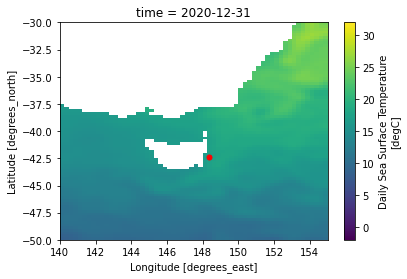

In [103]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 148.36, lat =-42.48, method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(-50,-30)
ax.set_xlim(140,155);

In [128]:
%%time
tas_ds = data.sst.sel(lon = 148.36, lat = -42.48, 
             method='nearest').sel(time = slice("1982-01-01","2020-12-31")).load()

CPU times: user 349 ms, sys: 28.8 ms, total: 378 ms
Wall time: 6min 44s


In [129]:
data.time

<xarray.DataArray 'time' (time: 14367)>
array(['1981-09-01T00:00:00.000000000', '1981-09-02T00:00:00.000000000',
       '1981-09-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2020-12-31
Attributes:
    long_name:     Time
    delta_t:       0000-00-01 00:00:00
    avg_period:    0000-00-01 00:00:00
    axis:          T
    actual_range:  [66352. 66473.]
    _ChunkSizes:   1

In [130]:
tas_ds.to_netcdf('tas_ds.nc')

In [111]:
#Uncomment line below to start from here
tas_ds=xr.open_dataset('tas_ds.nc').sst

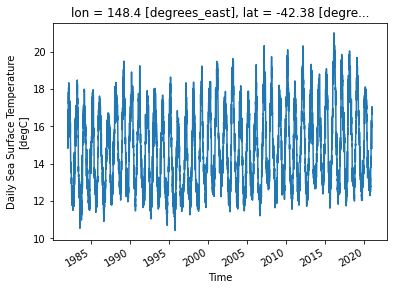

In [132]:
tas_ds.plot()

In [133]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2020,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [139]:
# Detect MHW events
mhws_case4, clim_case4 = mhw.detect(t, tas_ds.values, climatologyPeriod=[2015, 2016])

In [144]:
# Find largest event
ev = np.argmax(mhws_case4['intensity_max'])
print ('Maximum intensity:', mhws_case4['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case4['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case4['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case4['duration'][ev], 'days')
print ('Start date:', mhws_case4['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case4['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 2.9790757702242914 deg. C
Average intensity: 2.230957138922904 deg. C
Cumulative intensity: 31.233399944920656 deg. C-days
Duration: 14 days
Start date: 22 November 2017
End date: 05 December 2017


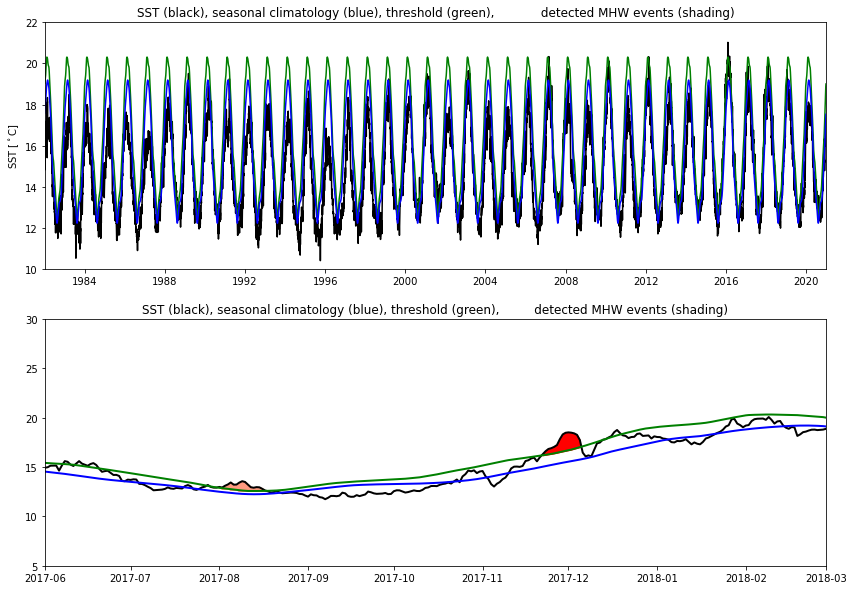

In [154]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, tas_ds, 'k-')
plt.plot(dates, clim_case4['thresh'], 'g-')
plt.plot(dates, clim_case4['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(tas_ds.min()-0.5, tas_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(10,22);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case4['time_start'][ev-1])[0][0]
    t2 = np.where(t==mhws_case4['time_end'][ev-1])[0][0]
    plt.fill_between(dates[t1:t2+1], tas_ds[t1:t2+1], clim_case4['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case4['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case4['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], tas_ds[t1:t2+1], clim_case4['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, tas_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case4['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case4['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim(date(2017,6,1), date(2018,3,1))
plt.ylim(5,30);

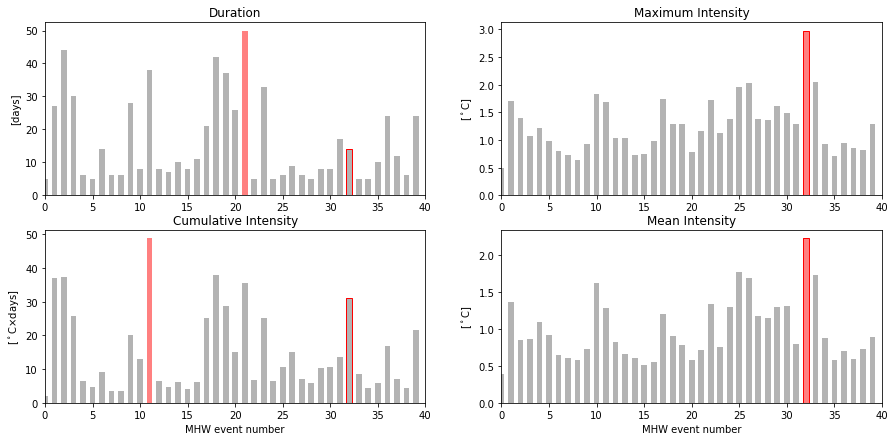

In [155]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case4['duration'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case4['intensity_max'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case4['intensity_mean'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case4['intensity_cumulative'])
plt.bar(range(mhws_case4['n_events']), mhws_case4['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case4['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case4['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case4['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

In [157]:
mhws_case4['n_events']

40

In [158]:
rank, returnPeriod = mhw.rank(t, mhws_case3)
print ("The 2015-16 Tasman Sea event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2015-16 Tasman Sea event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2015-16 Tasman Sea event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2015-16 Tasman Sea event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2015-16 Tasman Sea event is ranked number 6 by duration
The 2015-16 Tasman Sea event is ranked number 38 by maximum intensity
The 2015-16 Tasman Sea event is ranked number 44 by mean intensity
The 2015-16 Tasman Sea event is ranked number 8 by cumulative intensity


#### Case 5 - Caribbean Sea 2010

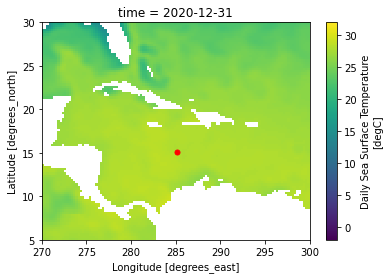

In [179]:
fig, ax = plt.subplots(1,1)
dummy = data.sst.sel(lon = 285, lat = 15, method='nearest')[0]
data.sst[-1,:].plot(ax=ax, vmin=-2,vmax=32)
ax.plot(dummy.lon.values, dummy.lat.values, color='r', ms=5,marker='o')
ax.set_ylim(5,30)
ax.set_xlim(270,300);

In [180]:
%%time
carib_ds = data.sst.sel(lon = 285, lat = 15, 
             method='nearest').sel(time = slice("1982-01-01","2020-12-31")).load()

CPU times: user 338 ms, sys: 32.3 ms, total: 370 ms
Wall time: 6min 44s


In [181]:
carib_ds.to_netcdf('carib_ds.nc')

In [182]:
#Uncomment line below to start from here
carib_ds=xr.open_dataset('carib_ds.nc').sst

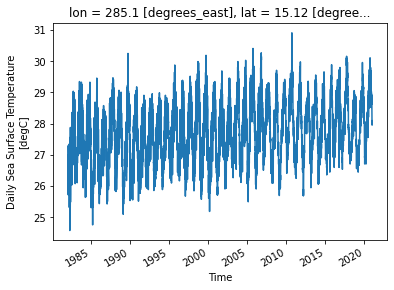

In [183]:
carib_ds.plot()

In [184]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2020,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]

In [185]:
# Detect MHW events
mhws_case5, clim_case5 = mhw.detect(t, carib_ds.values, climatologyPeriod=[2015, 2016])

In [186]:
# Find largest event
ev = np.argmax(mhws_case5['intensity_max'])
print ('Maximum intensity:', mhws_case5['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws_case5['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws_case5['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws_case5['duration'][ev], 'days')
print ('Start date:', mhws_case5['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws_case5['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 1.7947080673710012 deg. C
Average intensity: 0.5569648996023794 deg. C
Cumulative intensity: 9.46840329324045 deg. C-days
Duration: 17 days
Start date: 06 September 2010
End date: 22 September 2010


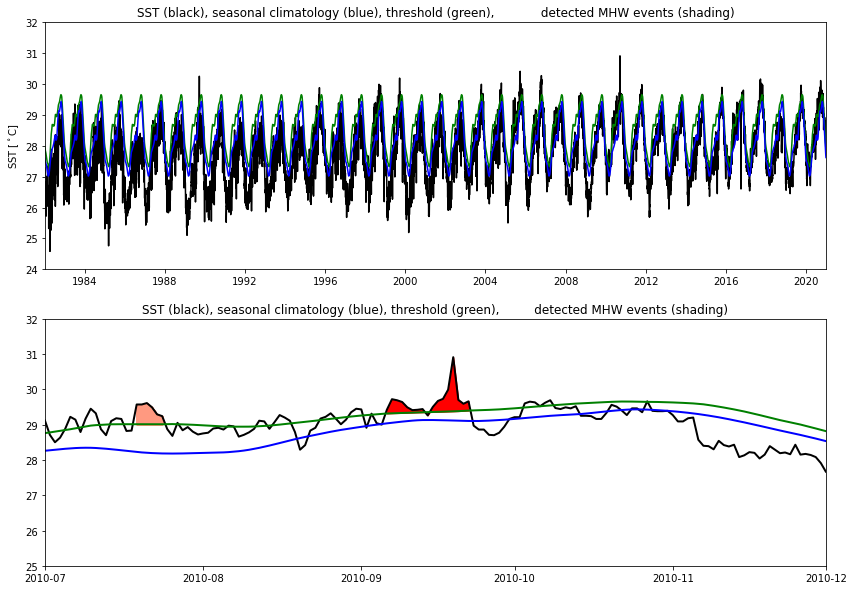

In [193]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, carib_ds, 'k-')
plt.plot(dates, clim_case5['thresh'], 'g-')
plt.plot(dates, clim_case5['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
           detected MHW events (shading)')
plt.ylim(carib_ds.min()-0.5, carib_ds.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.xlim(dates[0],dates[-1])
plt.ylim(24,32);

# second plot
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws_case5['time_start'][ev-1])[0][0]
    t2 = np.where(t==mhws_case5['time_end'][ev-1])[0][0]
    plt.fill_between(dates[t1:t2+1], carib_ds[t1:t2+1], clim_case5['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest (2012 NWA event) and shade accordingly
t1 = np.where(t==mhws_case5['time_start'][ev])[0][0]
t2 = np.where(t==mhws_case5['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], carib_ds[t1:t2+1], clim_case5['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, carib_ds, 'k-', linewidth=2)
plt.plot(dates, clim_case5['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim_case5['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), threshold (green), \
        detected MHW events (shading)')
plt.xlim(date(2010,7,1), date(2010,12,1))
plt.ylim(25,32);

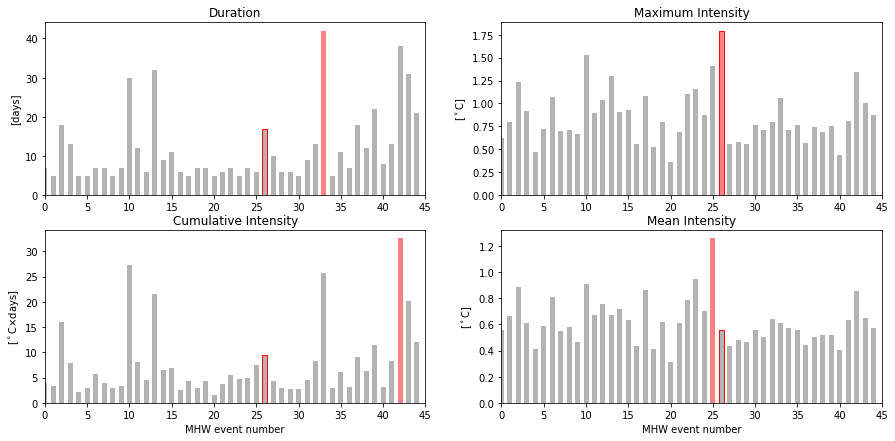

In [194]:
plt.figure(figsize=(15,7))
# Duration
plt.subplot(2,2,1)
evMax = np.argmax(mhws_case5['duration'])
plt.bar(range(mhws_case5['n_events']), mhws_case5['duration'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case5['duration'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case5['duration'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case5['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
# Maximum intensity
plt.subplot(2,2,2)
evMax = np.argmax(mhws_case5['intensity_max'])
plt.bar(range(mhws_case5['n_events']), mhws_case5['intensity_max'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case5['intensity_max'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case5['intensity_max'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case5['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
# Mean intensity
plt.subplot(2,2,4)
evMax = np.argmax(mhws_case5['intensity_mean'])
plt.bar(range(mhws_case5['n_events']), mhws_case5['intensity_mean'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case5['intensity_mean'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case5['intensity_mean'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case5['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel('MHW event number')
# Cumulative intensity
plt.subplot(2,2,3)
evMax = np.argmax(mhws_case5['intensity_cumulative'])
plt.bar(range(mhws_case5['n_events']), mhws_case5['intensity_cumulative'], width=0.6, \
        color=(0.7,0.7,0.7))
plt.bar(evMax, mhws_case5['intensity_cumulative'][evMax], width=0.6, color=(1,0.5,0.5))
plt.bar(ev, mhws_case5['intensity_cumulative'][ev], width=0.6, edgecolor=(1,0.,0.), \
        color='none')
plt.xlim(0, mhws_case5['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel('MHW event number');

In [195]:
mhws_case5['n_events']

45

In [196]:
rank, returnPeriod = mhw.rank(t, mhws_case3)
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['duration'][ev]) + " by duration")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_max'][ev]) + " by maximum intensity")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_mean'][ev]) + " by mean intensity")
print ("The 2017 Tasman Sea event is ranked number " \
        + str(rank['intensity_cumulative'][ev]) + " by cumulative intensity")

The 2017 Tasman Sea event is ranked number 29 by duration
The 2017 Tasman Sea event is ranked number 5 by maximum intensity
The 2017 Tasman Sea event is ranked number 3 by mean intensity
The 2017 Tasman Sea event is ranked number 15 by cumulative intensity
